In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import numpy as np

In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices())


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# LOAD DATASETS
trainDataset = tf.keras.utils.image_dataset_from_directory(
    'train',
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True
)

valDataset = tf.keras.utils.image_dataset_from_directory(
    'val',
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(224, 224),
    shuffle=False
)

Found 8000 files belonging to 4 classes.
Found 1600 files belonging to 4 classes.


2025-04-26 10:55:12.369627: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-04-26 10:55:12.369667: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-26 10:55:12.369679: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-26 10:55:12.369703: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-26 10:55:12.369721: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
from tensorflow.keras.applications.efficientnet import preprocess_input
# Clean augmentation pipeline
dataAugmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),

])

def augumentation(x, y):
    x = dataAugmentation(x)
    x = preprocess_input(x)
    return x, y

def normalisation(x, y):
    x = preprocess_input(x)
    return x, y

trainDataset = trainDataset.map(augumentation)
valDataset = valDataset.map(normalisation)


In [5]:
from tensorflow.keras import regularizers
# BUILD MODEL
baseModel = tf.keras.applications.EfficientNetB0(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet",
)
baseModel.trainable = False  

for layer in baseModel.layers[-30:]:
    layer.trainable = True  

efficientNetModel = models.Sequential([
    baseModel,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, use_bias=False, kernel_regularizer=regularizers.L2(1e-5)),
    layers.BatchNormalization(),
    layers.Activation('swish'),
    layers.Dropout(0.5),  
    layers.Dense(4, activation='softmax')
])

metricsList = ['accuracy']
efficientNetModel.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001),loss='categorical_crossentropy',metrics=metricsList)

efficientNetModel.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,439 (16.08 MB)

 Trainable params: 1,660,772 (6.34 MB)

 Non-trainable params: 2,553,667 (9.74 MB)

In [6]:
# CALLBACKS
callBacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("EfficientNet.keras", save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-5
    )

]

# TRAIN
EfficientNetHistory = efficientNetModel.fit(
    trainDataset,
    validation_data=valDataset,
    epochs=50,
    callbacks=callBacks,
)

Epoch 1/50


2025-04-26 10:55:45.724060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


250/250 ━━━━━━━━━━━━━━━━━━━━ 295s 1s/step - accuracy: 0.4873 - loss: 1.2572 - val_accuracy: 0.7819 - val_loss: 0.6087 - learning_rate: 1.0000e-04
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 200s 794ms/step - accuracy: 0.7434 - loss: 0.6750 - val_accuracy: 0.8225 - val_loss: 0.5218 - learning_rate: 1.0000e-04
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 179s 713ms/step - accuracy: 0.7957 - loss: 0.5505 - val_accuracy: 0.8350 - val_loss: 0.4772 - learning_rate: 1.0000e-04
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 234s 933ms/step - accuracy: 0.8113 - loss: 0.5034 - val_accuracy: 0.8319 - val_loss: 0.4689 - learning_rate: 1.0000e-04
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 205s 813ms/step - accuracy: 0.8301 - loss: 0.4637 - val_accuracy: 0.8562 - val_loss: 0.4235 - learning_rate: 1.0000e-04
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 185s 736ms/step - accuracy: 0.8466 - loss: 0.4362 - val_accuracy: 0.8575 - val_loss: 0.4400 - learning_rate: 1.0000e-04
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 179s 716ms/ste

In [7]:
efficientNetModel.save('EfficientNet.h5')

In [8]:
import pickle

# Save the history
with open('EfficientNet.pkl', 'wb') as f:
    pickle.dump(EfficientNetHistory.history, f)

In [ ]:
import pickle
with open('EfficientNet.pkl', 'rb') as f:
    loadedHistory = pickle.load(f)
loadedHistory
# Now you can use loaded_history['accuracy'], loaded_history['val_loss'], etc.


{'accuracy': [0.6014999747276306,
  0.7573750019073486,
  0.796750009059906,
  0.8149999976158142,
  0.8320000171661377,
  0.8411250114440918,
  0.8488749861717224,
  0.8571249842643738,
  0.8556249737739563,
  0.8573750257492065,
  0.8629999756813049,
  0.8643749952316284,
  0.8726249933242798,
  0.8698750138282776,
  0.874750018119812,
  0.8842499852180481,
  0.8836249709129333,
  0.8877500295639038,
  0.8861250281333923,
  0.8891249895095825,
  0.8949999809265137,
  0.8970000147819519,
  0.8996250033378601,
  0.8980000019073486,
  0.8960000276565552,
  0.8971250057220459,
  0.8972499966621399,
  0.9012500047683716,
  0.9037500023841858,
  0.9049999713897705,
  0.9017500281333923,
  0.8976250290870667],
 'loss': [1.0112953186035156,
  0.6384449601173401,
  0.5519366264343262,
  0.5037769675254822,
  0.4700421690940857,
  0.44573917984962463,
  0.43675217032432556,
  0.3993467390537262,
  0.39580976963043213,
  0.38708627223968506,
  0.38105446100234985,
  0.37279635667800903,
  0.354

In [ ]:
# Load the saved model
# efficientNetModel = tf.keras.models.load_model("Efficient_NetB0.keras")



In [10]:
testDataset = tf.keras.utils.image_dataset_from_directory(
    'test',
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(224, 224),
    shuffle=False
)

# Save class names before mapping
class_names = testDataset.class_names



Found 968 files belonging to 4 classes.


In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input


def normalisation(x, y):
    x = preprocess_input(x)
    return x, y

testDataset = testDataset.map(normalisation)


In [12]:
# Evaluate the model on the test dataset
loss, accuracy = efficientNetModel.evaluate(testDataset)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 462ms/step - accuracy: 0.9924 - loss: 0.0553
Test Loss: 0.0697
Test Accuracy: 98.76%


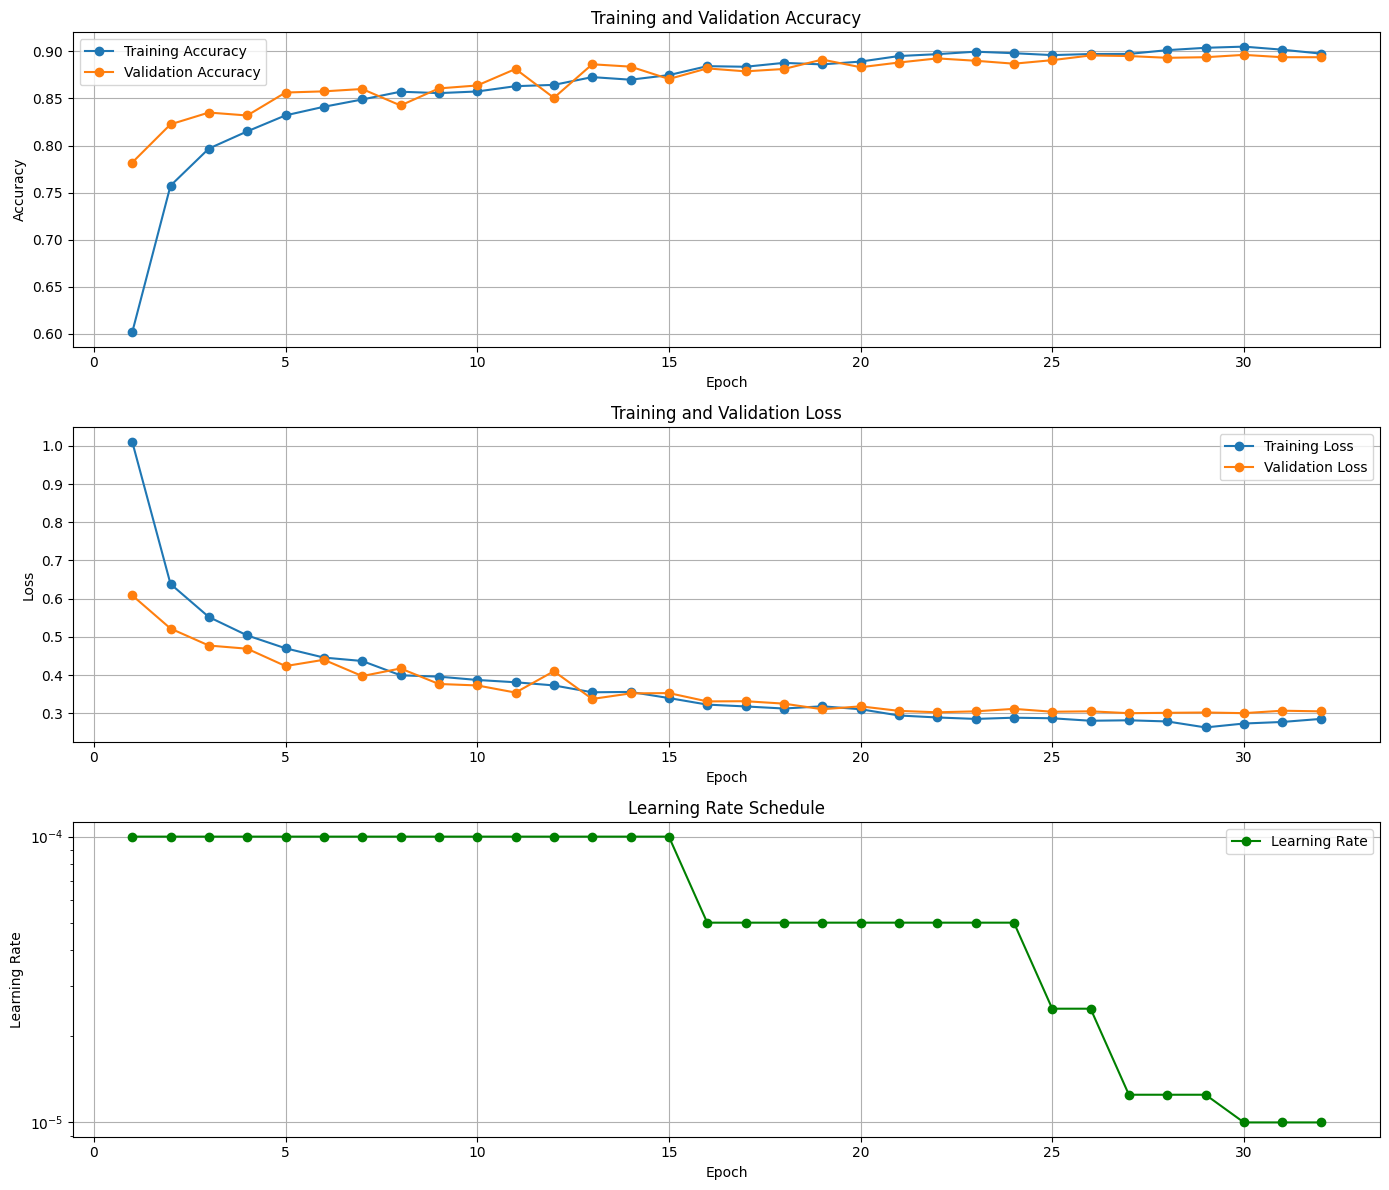

In [19]:
import matplotlib.pyplot as plt

# Access training history
acc = loadedHistory['accuracy']
val_acc = loadedHistory['val_accuracy']
loss = loadedHistory['loss']
val_loss = loadedHistory['val_loss']
lr = loadedHistory['learning_rate']  # Get learning rate history
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 12))  # Increased height for third subplot

# Accuracy Plot
plt.subplot(3, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(3, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Learning Rate Plot (new)
plt.subplot(3, 1, 3)
plt.plot(epochs_range, lr, label='Learning Rate', marker='o', color='green')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.yscale('log')  # Use log scale for better visualization of rate changes
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
import numpy as np

# Store true labels and predicted probabilities
y_true = []
y_pred_probs = []

for images, labels in testDataset:
    preds = efficientNetModel.predict(images)
    y_pred_probs.extend(preds)
    y_true.extend(labels.numpy())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

# Convert one-hot encoded labels to class indices
y_true_labels = np.argmax(y_true, axis=1)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Get class names
class_names = class_names


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

2025-04-26 13:35:42.565992: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

         CNV       0.96      1.00      0.98       242
         DME       1.00      0.99      0.99       242
      DRUSEN       1.00      0.97      0.98       242
      NORMAL       0.99      1.00      0.99       242

    accuracy                           0.99       968
   macro avg       0.99      0.99      0.99       968
weighted avg       0.99      0.99      0.99       968



Confusion Matrix in Array Format:
[[242   0   0   0]
 [  2 239   0   1]
 [  7   0 234   1]
 [  0   0   1 241]]


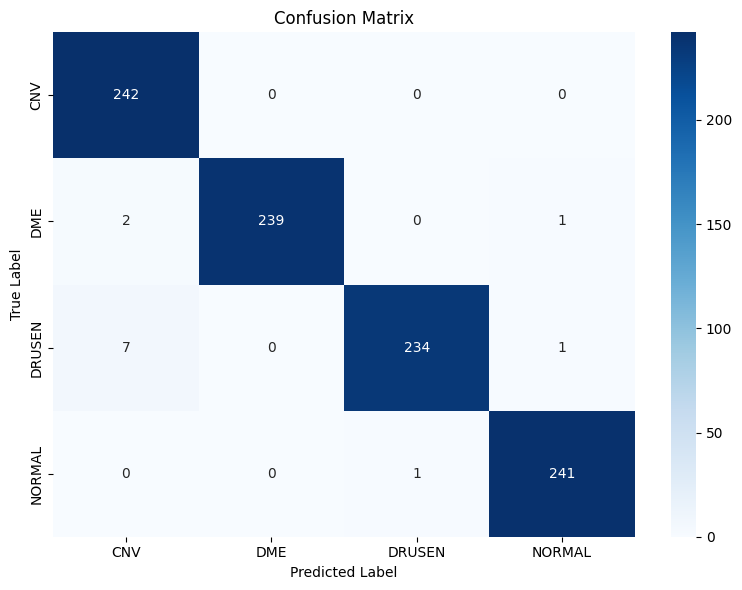

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
conf_mat = confusion_matrix(y_true_labels, y_pred_labels)

# Display the confusion matrix as an array
print("Confusion Matrix in Array Format:")
print(conf_mat)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [17]:
from sklearn.metrics import f1_score, precision_score, recall_score

f1_macro = f1_score(y_true_labels, y_pred_labels, average='macro')
f1_weighted = f1_score(y_true_labels, y_pred_labels, average='weighted')
precision = precision_score(y_true_labels, y_pred_labels, average='macro')
recall = recall_score(y_true_labels, y_pred_labels, average='macro')

print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")
print(f"Precision (Macro): {precision:.4f}")
print(f"Recall (Macro): {recall:.4f}")


F1 Score (Macro): 0.9876
F1 Score (Weighted): 0.9876
Precision (Macro): 0.9879
Recall (Macro): 0.9876


AUC for class 'CNV': 0.9998
AUC for class 'DME': 0.9981
AUC for class 'DRUSEN': 0.9994
AUC for class 'NORMAL': 0.9988


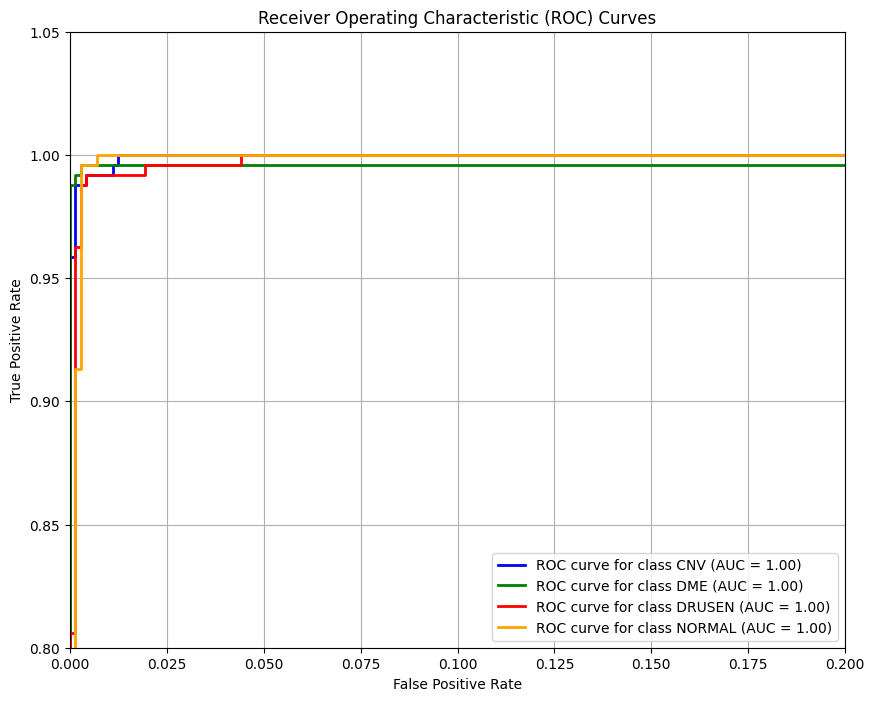

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from itertools import cycle

n_classes = y_true.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

# Per-class ROC and AUC
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f"AUC for class '{class_names[i]}': {roc_auc[i]:.4f}")

# Plot ROC curves
colors = cycle(['blue', 'green', 'red', 'orange', 'purple', 'brown'])

plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"ROC curve for class {class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 0.2])
plt.ylim([0.8, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
